# CIS-522 Week 10 Part 2
# Introduction to Transformers, BERT, and Language Models

**Instructor:** Lyle Ungar

**Content Creators:** Sanjeevini  Ganni, Ameet Rahane, Byron Galbraith

**Content Reviewers:** Ann-Katrin Reuel



---
## Preface
We recommend saving this notebook in your Google Drive (`File -> Save a copy in Drive`).

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W10D2'

# start timing
import time
try:t0;
except NameError: t0 = time.time()

##Tutorial Objectives


(1) Recognize NLP tasks: IR/search,  Question Answering/text completion, MT \\
(2) Understand distributional similarity on words and context including Context-oblivious embeddings (word2vec, glove, fastText) and multilingual embeddings  \\
(3) Attention  \\
(4) Context-sensitive embeddings: BERT and transformers: masking and self-attention \\
(5) The many flavors of BERT:  RoBERTa and DistilBERT \\
(6) Fine-tuning language embeddings \\
(7) Explaining NLP models \\
(8) Big language models: GPT-3 and friends  \\
(9) Societal: Bias in language embeddings \\


##Setup

In [ ]:
#@title Install
!pip install torchtext==0.4.0
!pip install transformers
# !git clone https://github.com/facebookresearch/fastText.git
# %cd fastText
# !pip install . 
# %cd ..

     |████████████████████████████████| 53 kB 563 kB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
     |████████████████████████████████| 3.8 MB 2.2 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
     |████████████████████████████████| 6.5 MB 33.0 MB/s 
     |████████████████████████████████| 895 kB 36.4 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#@title Imports and Seed
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import re
from IPython.display import Image
import os
from tqdm import tqdm_notebook as tqdm
import sys
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors, FastText
# import fasttext
import requests
import zipfile
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import urllib
import csv
from scipy.special import softmax

seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [ ]:
#@title Helper functions
def cosine_similarity(vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
def tokenize(sentences):
  #Tokenize the sentence
  #from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)
  
  return token

def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.title(title)
  plt.show()

###Data

In [ ]:
#@title Load Data

def load_dataset(emb_vectors, sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)



---
##Section 1: Transformers

Video available at https://youtube.com/watch?v=g860drKesIw


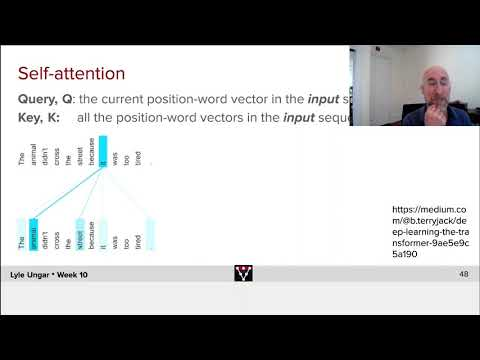

In [ ]:
#@title Video : Self-attention
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="g860drKesIw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Transformers! Like CNNs and LSTMs, this base model architecture has been the foundation of many very successful models such as BERT and friends. It has seen tremendous use in the NLP space, and there have been effforts to extend it to the audio and visual domains as well. The original paper, [Attention Is All You Need (Vaswani et al. 2017)](https://arxiv.org/abs/1706.03762), is very readable and you are encouraged to take a look.

The Transformer model is fundamentally an encoder-decoder model that operates on sequences of tokens. Both the encoder and decoder components are composed of stacks of submodules that use **only** attention mechanisms and linear weights to learn (there are no CNNs or RNNs). The architecture schematic looks like the following:

![transformer architecture](https://d2l.ai/_images/transformer.svg)

In the rest of this section we will be going over the various building blocks that go into Transformers. The goal here is not to train anything (that is left for a homework assignment). Rather, the emphasis is on understanding what all the pieces do and how they fit together.

*Note:* Many of the images in this section are taken from Dive Into Deep Learning's chapter on [Attention Mechanisms](https://d2l.ai/chapter_attention-mechanisms/index.html). You are encouraged to check that out for additional details and implementations.



### Self-Attention

Transformers make use of something called self-attention as a critical component to the entire operation. What does that mean in the context of attention mechanisms? If you recall, attention mechanisms in machine learning have three components:

 - the values V (the things you perceive i.e. model inputs)
 - the query Q (the thing you want to attend to)
 - the keys K (a mapping between queries and values)
 
Generally the number and dimensionality of queries and values can all be different. In self-attention, the queries, keys, and values are all drawn from the same set of inputs. In other words, we don't need to specify anything about what and how queries and keys are formed, as they come straight from the data just like the values!

Take a minute and check out the following article; It has detailed graphical explanation on how to calculate attention scores 
https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

Ok, so we know that our queries, keys, and values come from our input sequence, but which attention mechanism should we use?

### Masked Scaled Dot Product Attention

Video available at https://youtube.com/watch?v=VtaGIp_9j1w


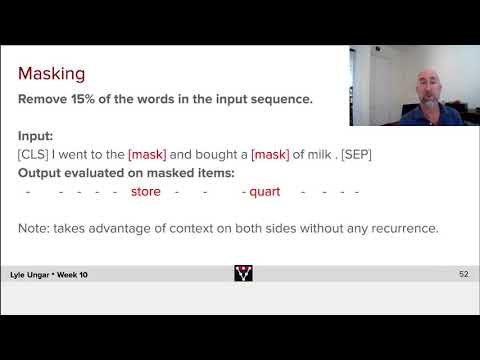

In [ ]:
#@title Video : Masking
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VtaGIp_9j1w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Masking is used to hide values from being attended to, including \
(a) words that are hidden for self-supervised learning, \
(b) padding tokens, and \
(c) in the seq2seq tasks in the original Transformers paper, everything that came after the next token in the output training (to enforce autoregressive behavior). 

BERT, on the other hand, masks out individual tokens within the input sequence and everything but those tokens on the output side. This provides a more bidirectional-style embedding learning strategy. 

This is accomplished by setting every element we want to mask to $-\infty$ before applying softmax, which has the effect of giving that element a probability of 0.

We've provided a masked softmax function below, which assumes a binary matrix of size (batch_size, n_tokens) where a value of 0 indicates that token should be masked.


In [ ]:
def masked_softmax(x, mask):
  """ Applies softmax on a masked version of the input.
  Args:
    x (n_batch, n_tokens, t_tokens): - the scaled dot product of Q and K
    mask (n_batch, n_tokens): - binary mask, all values = 0 will be set to -inf
  Returns:
    (n_batch, n_tokens, n_tokens): the result of applying softmax along the last
                                   dimension of the masked input.
  """
  return F.softmax(x.masked_fill_(mask.unsqueeze(1) == 0, float('-inf')), dim=-1)

#### Masked Scaled Dot Product Attention Module
Next, we will implement the forward method of a PyTorch module for computing the masked scaled dot product attention function. This is represented by the following equation:

$$
\alpha(Q, K, V, M) = \mathrm{masked\ softmax} \left( \frac{QK^T}{\sqrt d_k}, M \right) V
$$

where $Q$ is the query tensor, $K$ is the key tensor, $V$ is the value tensor, $M$ is the masking tensor, and $d_k$ is the dimensionality of our embeddings.

PyTorch provides us with the very useful [`torch.bmm`](https://pytorch.org/docs/stable/generated/torch.bmm.html) function to compute matrix multiplication over batches while preserving the batch dimension. You will also want to make use of the [`torch.transpose`](https://pytorch.org/docs/stable/generated/torch.transpose.html#torch.transpose) function to get the transpose of the keys tensor while also preserving the batch dimension.

To calculate the masked scaled dot product attention, we will first get the dot product from the query and key. We divide the dot product by the square root of the embedding length to scale it. Then we apply the masked softmax function to get the scores. By multiplying the scores and the values we get the masked scaled dot product attention.

*NOTE:* Dropout is normally applied to the `scaled_dot_product` quantity before softmax is applied during training. However, in the interests of clarity, we are omitting it here.

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.embed_dim = embed_dim

  def forward(self, queries, keys, values, mask):
    """
    Args:
      queries (n_batch, n_tokens, embed_dim): queries (Q) tensor
      keys (n_batch, n_tokens, embed_dim): keys (K) tensor
      values (n_batch, n_tokens, embed_dim): values (V) tensor
      mask (n_batch, n_tokens): binary mask tensor
    Returns:
      (n_batch, n_tokens, embed_dim): scaled dot product attention tensor
    """
    scaled_dot_product = torch.bmm(queries, torch.transpose(keys, 1, 2)) / np.sqrt(self.embed_dim)
    masked_softmax_scores = masked_softmax(scaled_dot_product, mask)
    attention = torch.bmm(masked_softmax_scores, values)
    return attention

torch.manual_seed(522)
batch_size, n_tokens, embed_dim = 1, 3, 4
tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
attention = ScaledDotProductAttention(embed_dim)
mask = torch.ones((batch_size, n_tokens))
print(attention(tokens, tokens, tokens, mask))
mask[0, 2:] = 0
print(attention(tokens, tokens, tokens, mask))

tensor([[[-0.2151, -0.0403,  0.9237, -1.6000],
         [ 0.4216,  1.3972,  1.3613, -0.0161],
         [ 0.0862,  0.7809,  1.1435, -0.8234]]])
tensor([[[-0.2688, -0.3399,  0.8707, -1.7680],
         [ 0.5448,  1.5134,  1.4313,  0.2591],
         [ 0.1679,  0.6550,  1.1717, -0.6798]]])


Self-attention is great, but it has two shortcomings:

1. It doesn't let us specify or control what gets attended to and thus will converge on only one strategy due to averaging. (Like short-term attention or long-term attention).

2. There is no implicit ordering or notion of relative position of the input tokens to each other unlike in RNNs and ConvNets.

We know things about natural language, such as that word order matters and there are many different grammatical and syntactic features that imbue useful meaning. How do we overcome this?

First, let's address the attention strategy problem. One answer to only having a single attention strategy is to have many!

### Multi-Head Attention

In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.

Multi-head attention mechanism is employed by Transformers to concurrently learn multiple different attention strategies or "heads." This is accomplished by passing each of the queries, keys, and values through single, fully-connected linear layers. Attention training is then conducted on all splits, which then get joined together at the end and passed through a linear layer to achieve the final output.

![multi-head attention diagram](https://d2l.ai/_images/multi-head-attention.svg)

Now, to avoid poor scaling performance with each attention head we add, we can take advantage of the fact that we only need to compute matrix multiplications. By effectively making the dimensionality of the newly made query, key, and value heads equal to the original embedding dimension cleanly divided by the number of heads, we can keep the heads strided in one tensor and thus compute the attention scores of all heads in a single call.

The methods to shuffle the data around for the input values (queries, keys, values) and then to unshuffle it for the output are provided below.

In [ ]:
def mha_transform_input(x, n_heads, head_dim):
  """ Restructure the input tensors to compute the heads in parallel
  Requires that head_dim = embed_dim / n_heads
  Args:
    x (n_batch, n_tokens, embed_dim): input tensor, one of queries, keys, or values
    n_heads (int): the number of attention heads
    head_dim (int): the dimensionality of each head
  Returns:
    (n_batch*n_heads, n_tokens, head_dim): 3D Tensor containing all the input heads
  """
  n_batch, n_tokens, _ = x.shape    
  x = x.reshape((n_batch, n_tokens, n_heads, head_dim))
  x = x.permute(0, 2, 1, 3)
  return x.reshape((n_batch * n_heads, n_tokens, head_dim))
  
def mha_transform_output(x, n_heads, head_dim):
  """ Restructures the output back to the original format 
  Args:
    x (n_bacth*n_heads, n_tokens, head_dim): multi-head representation tensor
    n_heads (int): the number of attention heads
    head_dim (int): the dimensionality of each head
  Returns:
    (n_batch, n_tokens, embed_dim): 3D Tensor containing all the input heads
  """
  n_concat, n_tokens, _ = x.shape
  n_batch = n_concat // n_heads
  x = x.reshape((n_batch, n_heads, n_tokens, head_dim))
  x = x.permute(0, 2, 1, 3)
  return x.reshape((n_batch, n_tokens, n_heads * head_dim))

#### Multi-Head Attention Module
Next we will show you how to implement the forward method of a PyTorch module for handling the multi-head attention mechanism. Each of the Q, K, and V inputs need to be run through their corresponding linear layers and then transformed using `mha_transform_input`. You then pass these to our scaled dot product attention module, transform that output back using `mha_transform_output`, and then run that though the corresponding output linear layer.

*NOTE:* In the original Transformers paper, the linear layers were just weight matrices with no bias term which is reproduced here by using `Linear` layers and setting bias to False.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, embed_dim):
    super().__init__()
    self.n_heads = n_heads
    self.head_dim = embed_dim // n_heads
    
    self.attention = ScaledDotProductAttention(embed_dim)
    self.query_fc = nn.Linear(embed_dim, embed_dim, bias=False)
    self.key_fc = nn.Linear(embed_dim, embed_dim, bias=False)
    self.value_fc = nn.Linear(embed_dim, embed_dim, bias=False)
    self.out_fc = nn.Linear(embed_dim, embed_dim, bias=False)
  
  def forward(self, queries, keys, values, mask):
    """
    Args:
      queries (n_batch, n_tokens, embed_dim): queries (Q) tensor
      keys (n_batch, n_tokens, embed_dim): keys (K) tensor
      values (n_batch, n_tokens, embed_dim): values (V) tensor
      mask (n_batch, n_tokens): binary mask tensor
    Returns:
      (n_batch, n_tokens, embed_dim): multi-head attention tensor
    """
    q_heads = mha_transform_input(self.query_fc(queries), self.n_heads, self.head_dim)
    k_heads = mha_transform_input(self.key_fc(keys), self.n_heads, self.head_dim)
    v_heads = mha_transform_input(self.value_fc(values), self.n_heads, self.head_dim)

    attention_heads = self.attention(q_heads, k_heads, v_heads, mask)
    attention = self.out_fc(mha_transform_output(attention_heads, self.n_heads, self.head_dim))
    return attention
 
torch.manual_seed(522)
n_heads, batch_size, n_tokens, embed_dim = 2, 1, 3, 4
tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
mask = torch.ones((batch_size, n_tokens))
attention = MultiHeadAttention(n_heads, embed_dim)
attention(tokens, tokens, tokens, mask)

tensor([[[ 0.3333, -0.0364, -0.1987, -0.4199],
         [ 0.2994, -0.0443, -0.1923, -0.3780],
         [ 0.3241, -0.0436, -0.2019, -0.4060]]], grad_fn=<UnsafeViewBackward0>)

So we have a solution for enabling multiple different attention strategies to be applied. But how about knowing where each token is in the sequence? Unlike RNNs that recurrently process tokens of a sequence one by one, self-attention ditches sequential operations in favor of parallel computation. Well, what if we just explicitly added some piece of information to the input representation that encodes each token's position?

Positional encodings can be either learned or fixed. While you can likely imagine ways to do this, Transformers use fixed positional encoding based on sine and cosine functions:

$$
p_{i,2j} = \sin \left( \frac{i}{10000^{2j/d}} \right) \\
p_{i,2j+1} = \cos \left( \frac{i}{10000^{2j/d}} \right)
$$

where $i$ and $j$ are iterated over the rows (tokens) and columns (embedding dimensions), respectively. This likely seems strange at first, but it has the neat effect of
1. providing unique values across the matrix elements
2. uses float values which easily add to the input embedded tokens


### Positional Encoding Module
Next we'll show you how to create the forward method for a PyTorch module that will add positional embeddings to an input batch of tokens. The position embedding values are already computed and cached for you.

*NOTE:* Dropout is normally applied to the output of this module during training, but we have omitted it for clarity.

Video available at https://youtube.com/watch?v=FoRWkEAJDtg


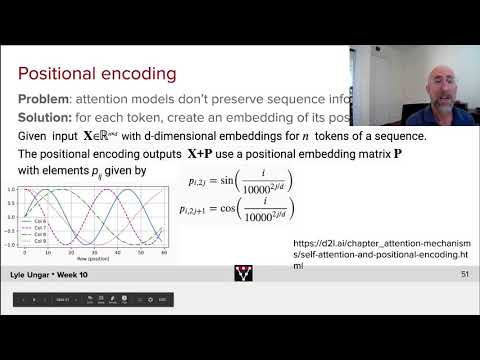

In [ ]:
#@title Video : Positional Encoding
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="FoRWkEAJDtg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

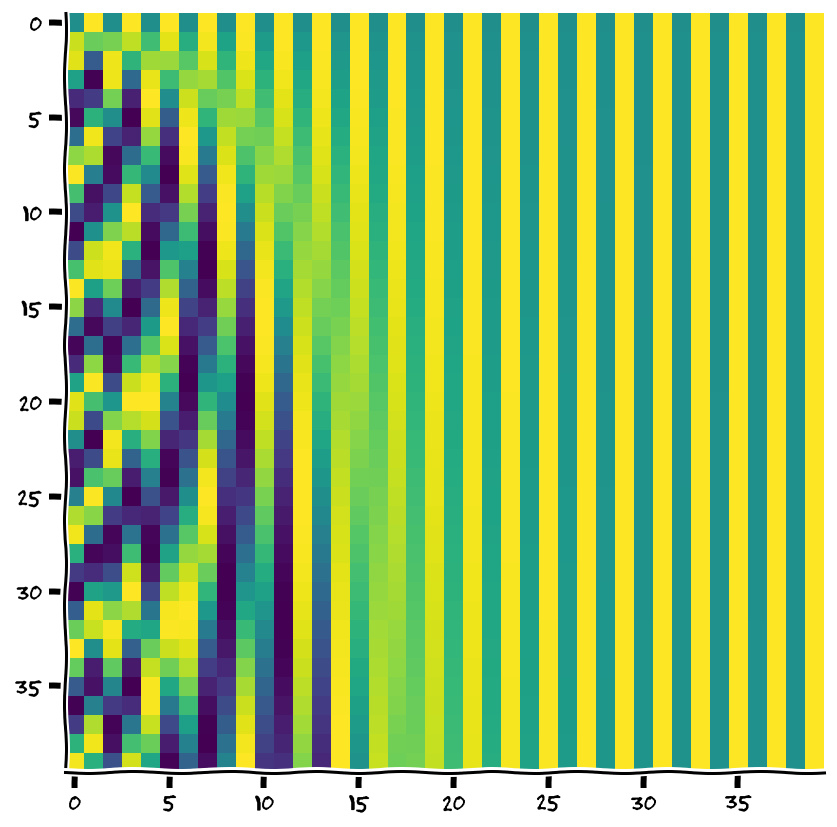

In [ ]:
class PositionalEncoder(nn.Module):
  def __init__(self, embed_dim, max_len=1000):
    super().__init__()
    self.position_embedding = torch.zeros((1, max_len, embed_dim))
    i = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
    j2 = torch.arange(0, embed_dim, step=2, dtype=torch.float32)
    x = i / torch.pow(10000, j2 / embed_dim)
    self.position_embedding[..., 0::2] = torch.sin(x)
    self.position_embedding[..., 1::2] = torch.cos(x)        

  def forward(self, x):
    x_plus_p = x + self.position_embedding[:, :x.shape[1]]
    return x_plus_p
  
with plt.xkcd():
   n_tokens, embed_dim = 40, 40
   pos_enc = PositionalEncoder(embed_dim) 
   p = pos_enc(torch.zeros((1, n_tokens, embed_dim)))
   plt.imshow(p.squeeze())
   p

### The Encoder

We now have almost everything we need to assemble the full Transformer network. There are just two more modules we need to quickly discuss, and then we will get to putting them all together.

Transformer architecture for reference:
<div>
<img src="https://d2l.ai/_images/transformer.svg" width="275"/>
</div>

First, there is the residual layer norm that appears after every other component. In all cases, this takes the output of the previous component, sums it with the input to that component (the residual connection), and then normalizes the result across the layer.

Second is the positionwise feed forward network that appears after the attention components. It is a two layer fully connected module with a ReLU activation in between. 

These are provided below. Note that dropout would normally be applied in various places in these modules during training, but we have omitted it for clarity.

In [ ]:
class ResidualNorm(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
  
  def forward(self, x, residual):
    return self.norm(x + residual)

class Feedforward(nn.Module):
  def __init__(self, embed_dim, hidden_dim):
    super().__init__()
    self.fc1 = nn.Linear(embed_dim, hidden_dim)    
    self.fc2 = nn.Linear(hidden_dim, embed_dim)
  
  def forward(self, x):
    return self.fc2(F.relu(self.fc1(x)))

Now that we have all the modules we need, we can begin assembling the bigger modules. First we will look at the Encoder Block. The actual encoder will be made up of some number of these stacked together.

#### Exercise 1.1: Encoder Block Module
In this exercise you will create the forward method of the PyTorch module representing the Encoder Block of the Transformer. The Encoder Block has the following architecture:
1. a multi-head attention module using self-attention
2. 1st residual layer norm
3. feed-forward model
4. 2nd residual layer norm


In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, n_heads, embed_dim, hidden_dim):
    super().__init__()    
    self.attention = MultiHeadAttention(n_heads, embed_dim)
    self.norm1 = ResidualNorm(embed_dim)
    self.feedforward = Feedforward(embed_dim, hidden_dim)
    self.norm2 = ResidualNorm(embed_dim)

  def forward(self, src_tokens, src_mask):
    """
    Args:
      src_tokens (n_batch, n_tokens, embed_dim): the source sequence
      src_mask (n_batch, n_tokens): binary mask over the source
    Returns:
      (n_batch, n_tokens, embed_dim): the encoder state
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("EncoderBlock")
    ####################################################################
    # First compute self-attention on the source tokens by passing them in
    # as the queries, keys, and values to the attention module.
    self_attention = ...
    # Next compute the norm of the self-attention result with a residual
    # connection from the source tokens
    normed_attention = ...
    # Pass the normed attention result through the feedforward component
    ff_out = ...
    # Finally compute the norm of the feedforward output with a residual
    # connection from the normed attention output
    out = ...
    return out

# Uncomment below to test your module
# torch.manual_seed(522)
# n_heads, batch_size, n_tokens, embed_dim, hidden_dim = 2, 1, 3, 4, 8
# tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
# mask = torch.ones((batch_size, n_tokens))
# encoder = EncoderBlock(n_heads, embed_dim, hidden_dim)
# encoder(tokens, mask)

Now that we have our Encoder Block, we can chain these together in a stack to get the full Encoder module. We will include the embedding layer and positional encoding step of the source tokens here as well. The input to this module then will be a tensor of a batch of token IDs and corresponding mask.

For instance, if our entire corpus was the English sentence: `Cat sat on the mat` and we tokenized by word, our vocab size would be 5 as there are 4 unique words. Converting this sentence to IDs would be `[[0,1,2,3,4]]`.

The code for the Encoder module is provided below.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, n_heads, n_blocks):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.positional_encoding = PositionalEncoder(embed_dim)
    self.encoder_blocks = nn.ModuleList([
      EncoderBlock(n_heads, embed_dim, hidden_dim)
      for _ in range(n_blocks)])
  
  def forward(self, src_tokens, src_mask):
    x = self.embedding(src_tokens)
    x = self.positional_encoding(x)
    for block in self.encoder_blocks:
      x = block(x, src_mask)
    return x


vocab_size = 5
n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
enc = Encoder(vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
src_tokens = torch.IntTensor([[0,1,2,3,4]])
src_mask = torch.IntTensor([[1,1,1,1,1]])
enc(src_tokens, src_mask)

tensor([[[-1.4173,  1.3388, -0.2736,  0.3521],
         [-0.8512,  1.5628, -0.8943,  0.1828],
         [-0.9568,  0.8616, -1.0335,  1.1287],
         [-1.6040,  0.8962, -0.0782,  0.7860],
         [-1.7117,  0.8187,  0.4703,  0.4227]]],
       grad_fn=<NativeLayerNormBackward0>)

### The Decoder

Like the encoder, the decoder is made up of a stack of repeating Decoder Blocks. Decoder Blocks are similar to the Encoder ones with an additional multi-head attention component that doesn't use self-attention, but instead gets the queries from the decoder's self-attention component and the keys and values from the encoder's output.

#### Exercise 1.2: Decoder Block Module
In this exercise you will create the forward method of the PyTorch module representing the Decoder Block of the Transformer. The Decoder Block has the following architecture:
1. a multi-head attention using self-attention
2. 1st residual layer norm
3. a 2nd multi-head attention that incorporates the encoder output
4. 2nd residual layer norm
5. feed-forward model
6. 3rd residual layer norm

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, n_heads, embed_dim, hidden_dim):
    super().__init__()    
    self.self_attention = MultiHeadAttention(n_heads, embed_dim)
    self.norm1 = ResidualNorm(embed_dim)
    self.encoder_attention = MultiHeadAttention(n_heads, embed_dim)
    self.norm2 = ResidualNorm(embed_dim)
    self.feedforward = Feedforward(embed_dim, hidden_dim)
    self.norm3 = ResidualNorm(embed_dim)

  def forward(self, tgt_tokens, tgt_mask, encoder_state, src_mask):
    """
    Args:
      tgt_tokens (n_batch, n_tokens, embed_dim): the target sequence
      tgt_mask (n_batch, n_tokens): binary mask over the target tokens
      encoder_state (n_batch, n_tokens, embed_dim): the output of the encoder pass
      src_mask (n_batch, n_tokens): binary mask over the source tokens
    Returns:
      (n_batch, n_tokens, embed_dim): the decoder state
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("DecoderBlock")
    ####################################################################
    # First compute self-attention on the target tokens by passing them in
    # as the queries, keys, and values to the attention module along with the
    # target mask.
    self_attention = ...
    # Next compute the norm of the self-attention result with a residual
    # connection from the target tokens
    normed_self_attention = ...
    # Compute the encoder attention by using the normed self-attention output as
    # the queries and the encoder state as the keys and values along with the
    # source mask.
    encoder_attention = ...
    # Next compute the norm of the encoder attention result with a residual
    # connection from the normed self-attention
    normed_encoder_attention = ...
    # Pass the normed encoder attention result through the feedforward component
    ff_out = ...
    # Finally compute the norm of the feedforward output with a residual
    # connection from the normed attention output
    out = ...
    return out

# Uncomment below to test your module
# torch.manual_seed(522)
# n_heads, batch_size, n_tokens, embed_dim, hidden_dim = 2, 1, 3, 4, 8
# tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
# src_mask = torch.ones((batch_size, n_tokens))
# tgt_mask = torch.ones((batch_size, n_tokens))
# encoder = EncoderBlock(n_heads, embed_dim, hidden_dim)
# decoder = DecoderBlock(n_heads, embed_dim, hidden_dim)
# encoder_state = encoder(tokens, src_mask)
# decoder(tokens, tgt_mask, encoder_state, src_mask)

The Decoder module ends up just the same as the Encoder module with one key difference: the forward method needs to also accept the output of the encoder as well as the source token mask.

For instance, let's assume we are doing a translation task and want to translate the English `Cat sat on the mat` into the French `Chat assis sur le tapis`. Out target vocab size is also 5 and would be similarly converted into IDs as `[[0,1,2,3,4]]`.

The code for the Decoder module is presented below.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, n_heads, n_blocks):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.positional_encoding = PositionalEncoder(embed_dim)
    self.decoder_blocks = nn.ModuleList([
      DecoderBlock(n_heads, embed_dim, hidden_dim)
      for _ in range(n_blocks)])
  
  def forward(self, tgt_tokens, tgt_mask, encoder_state, src_mask):
    x = self.embedding(tgt_tokens)
    x = self.positional_encoding(x)
    for block in self.decoder_blocks:
      x = block(x, tgt_mask, encoder_state, src_mask)
    return x

vocab_size = 5
n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
tgt_tokens = torch.IntTensor([[0,1,2,3,4]])
tgt_mask = src_mask = torch.IntTensor([[1,1,1,1,1]])
enc_state = torch.randn((1,5,4))
dec = Decoder(vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
dec(tgt_tokens, tgt_mask, enc_state, src_mask)

tensor([[[ 0.3149,  0.7643, -1.7089,  0.6296],
         [ 1.2156,  0.0026, -1.5526,  0.3343],
         [-0.3498, -1.1131,  1.6170, -0.1541],
         [ 1.4552, -1.3460,  0.1252, -0.2344],
         [-0.1210,  0.3113, -1.4862,  1.2960]]],
       grad_fn=<NativeLayerNormBackward0>)

### The Full Transformer Model

We can now put the Encoder and Decoder together to produce the full Transformer model.



#### Exercise 1.3: Transformer Module

In the last exercise for this section you will implement the forward method of the full Transformer module. First you will apply the source tokens and mask to the Encoder to get its output, then use that along with the target tokens and mask to produce the Decoder output. Finally we run the Decoder output through a linear layer to transform the embeddings back into vocab ID scores in order to determine the actual next word prediction.

In [ ]:
class Transformer(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks):
    super().__init__()
    self.encoder = Encoder(src_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
    self.decoder = Decoder(tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
    self.out = nn.Linear(embed_dim, tgt_vocab_size)

  def forward(self, src_tokens, src_mask, tgt_tokens, tgt_mask):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("DecoderBlock")
    ####################################################################
    # Compute the encoder output state from the source tokens and mask
    encoder_state = ...
    # Compute the decoder output state from the target tokens and mask as well
    # as the encoder state and source mask
    decoder_state = ...
    # Compute the vocab scores by passing the decoder state through the output
    # linear layer
    out = ...
    return out

# Uncomment below to test your module
# torch.manual_seed(522)
# src_vocab_size = tgt_vocab_size = 5
# n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
# src_tokens = tgt_tokens = torch.IntTensor([[0,1,2,3,4]])
# src_mask = tgt_mask = torch.IntTensor([[1,1,1,1,1]])

# transformer = Transformer(src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
# transformer(src_tokens, src_mask, tgt_tokens, tgt_mask)

### Summary
We've covered all the building blocks that make up the Transformer network architecture from the attention mechanism up to the fully combined encoder-decoder setup. The module versions presented here were often simplified in some ways and made more verbose in others to emphasize what each component is doing.

Video available at https://youtube.com/watch?v=_sKZpAptIZk


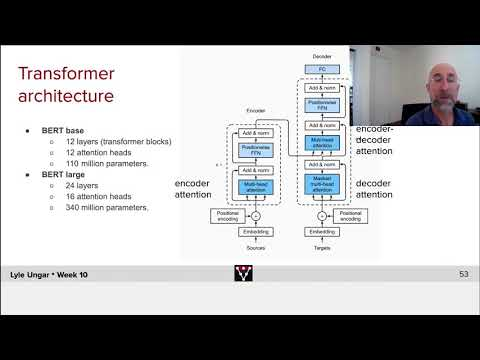

In [ ]:
#@title Video : Transformer Architecture
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="_sKZpAptIZk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

---
##Section 2: BERT and friends

Video available at https://youtube.com/watch?v=gEkmPb0140w


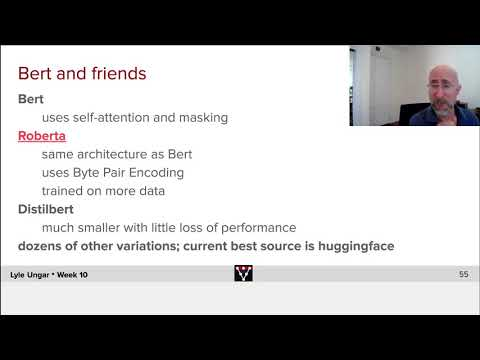

In [ ]:
#@title Video : Bert and Friends
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="gEkmPb0140w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

---
## Section 3: BERT

BERT, or Bidrectional Encoder Representations from Transforms, is a Transformer-based machine learning technique for NLP pre-training developed by Google. The original English BERT has two models: 

1. BERT$_{BASE}$: $12$ encoders with $12$ bidirectional self-attention heads
2. BERT$_{LARGE}$: $24$ encoders with $24$ bidirectional self-attention heads 

Both models are pre-trained with unlabeled data extracted from BooksCorpus with $800$M words and Wikipedia with $2500$M words. Importantly, unlike context-free models like GloVe or word2vec, BERT takes context into account for each occurrence of a given word.  For instance, whereas the vector for "running" will have the same word2vec vector representation for both of its occurrences in the sentences "He is running a company" and "He is running a marathon", BERT will provide a contextualized embedding that will be different according to the sentence.


Video available at https://youtube.com/watch?v=sFQGoswoaeI


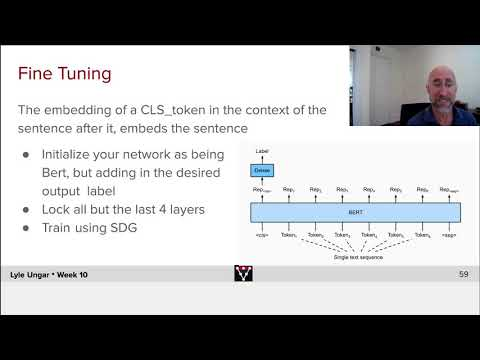

In [ ]:
#@title Video : Using BERT
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="sFQGoswoaeI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

---
## Section 4: RoBERTa

As can be seen by the name, RoBERTa builds on BERT, modifying key hyperparameters. It removes the next-sentence pretraining objective and trains with much larger mini-batches and learning rates. 

Spend some time playing with RoBERTa natural language inference at https://huggingface.co/roberta-large-mnli?text=The+dog+was+lost.+I+lost+an+animal.+. Additionally, spend some time looking at the other model examples at https://github.com/huggingface/transformers.


Roberta, introduced [here](https://arxiv.org/abs/1907.11692), stands for A Robustly Optimized BERT Pretraining Approach. RoBERTa builds on BERT's language masking strategy, where the system learns to predict intentionally hidden sections of text within otherwise unannotated language samples. It modifies key hyperparameters in BERT, removing BERT's next-sentence pretraining objective. This, alongside the larger mini-batch and learning rate, allows RoBERTA to improve ont he masked language modeling objective compared with BERT and leads to better downstream task performance. The changes in training causing a substantial increase in performance leads to the believe that BERt was relatively undertrained. 


## TweetEVAL Sentiment Analysis

We utilize an already finetuned network on sentiment analysis to write an example for sentiment analysis. This is a roBERTa model trained on ~58 million tweets and finetuned for sentiment analysis with the [TweetEval](https://arxiv.org/pdf/2010.12421.pdf) benchmark. We use huggingface to implement this. 


First, we preprocess the text and download our fine-tuned model. By fine-tuning, this model took the initial training done in the roBERTa paper and trained it additionally on a downstream sentiment analysis task. 


In [ ]:
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Now that we have our pytorch model ready, let's play with some text. As seen below, we take some input text (feel free to change this to whatever text you want to see the sentiment). The text is preprocessed usingour function above, then tokenized using the huggingface autotokenizer. Then, we sort the sentiments by their relative probabilities, which is what we see at the end. 

In [ ]:
text = "I'm sad :("
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)



ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) negative 0.9168
2) neutral 0.0727
3) positive 0.0105


---
## Section 5: BERT variations (DistilBERT)

https://arxiv.org/abs/1910.01108


DistilBERT, as the name suggests, is a "distilled" version of BERT: smaller, faster, cheaper, and lighter. Often times, having very large models is infeasible, as it requires a lot of compute time and resources. Specifically, we often need to run models on smaller devices, without the ability to run many large GPUs to train. DistilBERT is a pre-trained general-purpose language representation model, which we can then fine-tune to achieve good performance on a number of tasks. 


Let's use DistilBERT to write a small question answering system. Question answering systems automatically respond to a given query. The input will be framed with context and the question. For example:



---


Context :
The US has passed the peak on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month. The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world. \\
Question:
What was President Donald Trump's prediction?


---
Answer: 
some states would reopen this month.


---




In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering




tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',return_token_type_ids = True)
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad', return_dict=False)

context = "The US has passed the peak on new coronavirus cases, " \
          "President Donald Trump said and predicted that some states would reopen this month. " \
          "The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world."

question = "What was President Donald Trump's prediction?"

encoding = tokenizer.encode_plus(question, context)


input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

start_scores, end_scores = model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]))

ans_tokens = input_ids[torch.argmax(start_scores) : torch.argmax(end_scores)+1]
answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)

print ("\nQuestion: ",question)
print ("\nAnswer Tokens: ")
print (answer_tokens)




answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)

print ("\nAnswer : ",answer_tokens_to_string)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]


Question:  What was President Donald Trump's prediction?

Answer Tokens: 
['some', 'states', 'would', 're', '##open', 'this', 'month']

Answer :  some states would reopen this month


Cool! Go ahead and try your own questions and see how DistilBERT answers it! Let's try multiple questions at once (in a batch). 

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',return_token_type_ids = True)
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad', return_dict = False)

context = "The US has passed the peak on new coronavirus cases, " \
          "President Donald Trump said and predicted that some states would reopen this month." \
          "The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, " \
          "the highest for any country in the world."

print ("\n\nContext : ",context)

questions = ["What was President Donald Trump's prediction?",
             "How many deaths have been reported from the virus?",
             "How many cases have been reported in the United States?"]

question_context_for_batch = []

for question in questions :
    question_context_for_batch.append((question, context))

encoding = tokenizer.batch_encode_plus(question_context_for_batch,pad_to_max_length=True, return_tensors="pt")
input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
start_scores, end_scores = model(input_ids, attention_mask=attention_mask)

for index,(start_score,end_score,input_id) in enumerate(zip(start_scores,end_scores,input_ids)):
    max_startscore = torch.argmax(start_score)
    max_endscore = torch.argmax(end_score)
    ans_tokens = input_ids[index][max_startscore: max_endscore + 1]
    answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens, skip_special_tokens=True)
    answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)
    print ("\nQuestion: ",questions[index])
    print ("Answer: ", answer_tokens_to_string)



Context :  The US has passed the peak on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month.The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Question:  What was President Donald Trump's prediction?
Answer:  some states would reopen this month

Question:  How many deaths have been reported from the virus?
Answer:  30 , 826

Question:  How many cases have been reported in the United States?
Answer:  over 637 , 000


---
## Section 6: Explaining language models


In [ ]:
#@title Video : Explaining language models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="G38ZZNnXaQs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()


Video available at https://youtube.com/watch?v=G38ZZNnXaQs


## Quiz Question 1

In [ ]:
#@markdown Why would you expect part of speech tagging to be done closer to the input, and co-reference to be done more deeply in the network?
#report to Airtable
NLP_network_structure = '' #@param {type:"string"}

There are lots of tools out there to help visualize what's going on in NLP systems. If you want (this is not an assignment), play around with the demos at https://pair-code.github.io/lit/demos/.


---
## Section 7: Bias in Embeddings



Video available at https://youtube.com/watch?v=meUnCri_52c


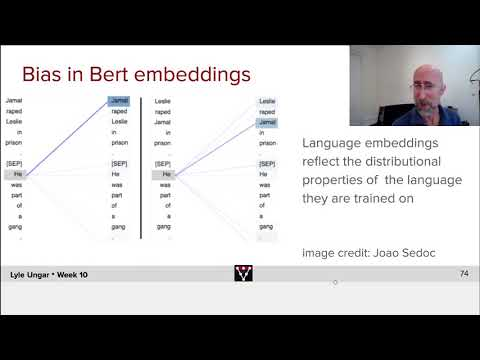

In [ ]:
#@title Video : Bias in Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="meUnCri_52c", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

You just saw how training on large amounts of historical text can introduce undesirable associations and outcomes. In this section we are going to explore this idea further as it pertains to coreference resolution.

Coreference resolution is the NLP task of finding all the terms that refer to an entity in a passage of text e.g. what noun phrase does a pronoun refer to. This can be quite difficult, even for humans, if the passage is ambiguous enough.

For example, in the sentence:

`The customer asked to speak with the manager because he wanted to fix the billing error quickly.`

what does `he` refer to? We can reasonably assume given the context that `he` refers to the customer. Furthermore, it shouldn't matter which pronoun (he/she/they) was in that spot, it should still refer back to the customer.

However this is not the case with some models! For example, here is the output of Huggingface's [Neural Coreference model](https://github.com/huggingface/neuralcoref) when we use `she` as the pronoun:

![coref with she](https://imgur.com/4FmN3ZC.png)

You can see that `she` is scored against all detected noun phrases and gets the highest score with `the customer`. So far so good. Now let's try it with `he` instead:

![coref with he](https://imgur.com/SOyLrtg.png)

The model has instead associated `he` with `the manager`, and quite strongly at that, even though that doesn't make sense contextually. As this is a neural-based model trained on historical data, one possibility is there were many instances where `he` and `manager` were associated, enough to get "distracted" by that signal over the rest of the sentence.



As was mentioned in the video, many people are actively working toward both identifying and mitigating these undesirable behaviors and also educating researchers, practitioners, and the general public about these issues. For instance, the sample sentence used above was taken from the [Winogender Schemas](https://github.com/rudinger/winogender-schemas), a set of sample sentences to check the variance in outcomes when only a single pronoun is changed.

#### Exercise 3: Explore Bias in Coreference Resolution Models

Two different coreference resolution models that have nice online demos are from [Huggingface](https://huggingface.co/coref/) and [AllenNLP](https://demo.allennlp.org/coreference-resolution). In this exercise, you will explore a variety of sentences with these two tools and see how they compare. Try the following sentences in both and see how they handle the change in pronoun:

`The doctor berated the nurse. He had come in late for the meeting.`

`The doctor berated the nurse. She had come in late for the meeting.`


## Quiz Questions 2, 3, and 4

In [ ]:
#@markdown Did Huggingface get it right?
huggingface_bias = '' #@param {type:"string"}

In [ ]:
#@markdown Did Allen Institute get it right?
#report to Airtable
allenInst_bias = '' #@param {type:"string"}

In [ ]:
#@markdown How might you "fine tune" Bert to reduce such errors?
#report to Airtable
fine_tune_away_bias = '' #@param {type:"string"}

---
# Wrap up


In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers and then click "Submit". If you're having any issues, fill out the form here: https://airtable.com/shrmbRA6gzPpBeaMd.

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: my_email;
except NameError: my_email = ""
try: NLP_network_structure;
except NameError: NLP_network_structure = ""
try: huggingface_bias;
except NameError: huggingface_bias = ""
try: allenInst_bias;
except NameError: huggingface_bias = ""
try: fine_tune_away_bias;
except NameError: fine_tune_away_bias = ""


times = np.array([t1])-t0

fields = {
    "pennkey": my_pennkey,
    "pod": my_pod, 
    "email": my_email, 
    "NLP_network_structure": NLP_network_structure,
    "huggingface_bias": huggingface_bias,
    "allenInst_bias": allenInst_bias,
    "fine_tune_away_bias": fine_tune_away_bias,
    "cumulative_times": times
}

src = "https://airtable.com/embed/shrmbRA6gzPpBeaMd?"

display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))



## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [ ]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))